# A simple 5-parameter $w_a$ blinded fit

### ROOT and blinding functions import
See https://cdcvs.fnal.gov/redmine/projects/gm2analyses/wiki/Library_installation for a local installation of Blinding libraries for Python3

In [1]:
import sys, math, os
# add brew ROOT (Mac) the system path from bash_profile 
# e.g. export JUPYROOT=/usr/local/Cellar/root/6.18.04/lib/root)
sys.path.append(os.environ["JUPYROOT"]) 
sys.path.append("Blinding/") # folder with Blinders and libBlinders.so
import ROOT as r
from ROOT import TFile, TStyle,TCanvas, gStyle, TF1, gROOT, TMath, TLegend
r.gROOT.Macro("~/rootlogon.C") #if you have a rootlogon.C / g2PlotStyle https://cdcvs.fnal.gov/redmine/projects/g-2/wiki/PlotStyleGuide
gStyle.SetOptStat(0) # we only want the event number in range (i.e. integral)
gStyle.SetOptFit(0) # use legend to put fit details 
c = TCanvas("c", "", 1800, 800) 
from BlindersPy3 import Blinders
from BlindersPy3 import FitType

Welcome to JupyROOT 6.18/04


### Set blinding here

In [3]:
# unblinded instance (for testing-only!)
# getBlinded = Blinders(FitType.Omega_a) # this will scream "You are not blind!"
# blinded=False

# blinded instance with your favorite phrase
getBlinded = Blinders(FitType.Omega_a, "EDM all day") # will tell you that you are blinded
# blinded=True 

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


### Define blinded fit function $N(t)=Ne^{-t/\tau}[1+A\cos(\omega_at+\phi)]$,
where  
[0] $N$ is the overall normalisation  
[1] $\tau$ is the boosted muon lifetime $\tau = \gamma \cdot \tau_0 = 29.3\cdot2.2=66.44 \, \mu$s  
[2] $A$ is the asymmetry  
[3] $\omega_a$ is the anomalous precision frequency  
[4] $\phi$ is the initial phase  

In [4]:
def blinded_wiggle_function(x, pars):
    norm  = pars[0]
    life  = pars[1]
    asym  = pars[2]
    R     = pars[3]
    phi   = pars[4]
    
    time  = x[0]
    omega = getBlinded.paramToFreq(R)
    
    return norm * math.exp(-time/life) * (1 + asym*math.cos(omega*time + phi))

### Open ROOT file with a wiggle histogram and set some cuts (time)

In [16]:
file= "DATA/Run1_4DS_ana.root"
path = "TrackSummary/FitResults/Times_gt_1800MeV" # plot path in the ROOT file 

# file= "DATA/VLEDM.root"
# file= "DATA/noEDM.root"
# path = "AllStationsNoTQ/TrackFit/t>0/0<p<3600/time_1800MeV" # plot path in the ROOT file 

xmin=30 # us 

# xmin=0 # us 
xmax=120 # us 
t_file = TFile.Open(file) 
h_wiggle = t_file.Get(path)

## Display the wiggle histogram

46131972 tracks in range 30 to 120 [us]


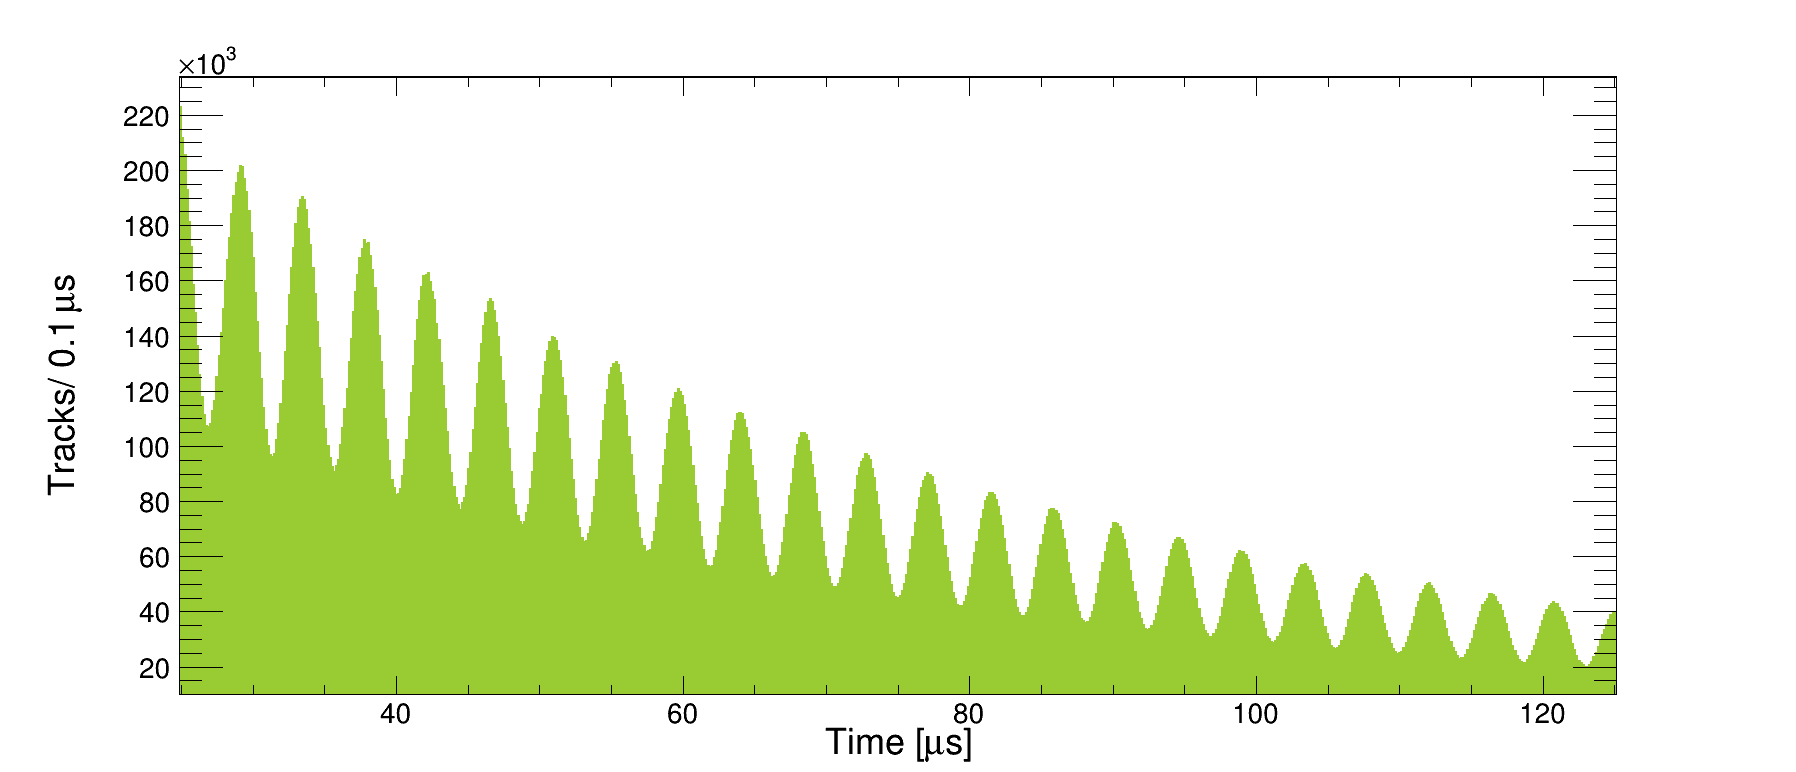

In [17]:
h_wiggle.Draw()
Xaxis = h_wiggle.GetXaxis()
Yaxis = h_wiggle.GetYaxis()
Xaxis.SetRangeUser(xmin-5, xmax+5) # apply the time cut (display purpose only +/-5 us to see start/end of the fit)
# Find the number of events in range
bmin = Xaxis.FindBin(xmin)
bmax = Xaxis.FindBin(xmax)
entries = h_wiggle.Integral(bmin,bmax)
print(int(entries), "tracks in range",xmin,"to",xmax,"[us]")
binW=h_wiggle.GetBinWidth(1) 
Xaxis.SetTitle("Time [#mus]")
h_wiggle.GetYaxis().SetTitle("Tracks/ %.1f #mus" % binW)
h_wiggle.GetXaxis().SetTitleOffset(0.8)
h_wiggle.GetYaxis().SetTitleOffset(0.8)
Xaxis.CenterTitle()
Yaxis.CenterTitle()
c.Draw()

## Now we can set some initial guess on the parameters and do a blinded fit

In [18]:
func = TF1("func", blinded_wiggle_function, xmin, xmax, 5) # use our defined function in range with 5 parameters
func.SetParNames('N','#tau','A','R','#phi') # name the parameters 
func.SetParameters(2.0e+05, 64.4 , 0.4 ,0.0, 0.0) # initial guess 
# func.SetParameters(2.0e+03, 64.4 , 0.4 ,0.0, 0.0) # initial guess 
func.SetLineColor(2) # red 
func.SetLineWidth(4) # red 
func.SetNpx(10000) # prevent under-sampling (display only)
if(blinded==False):
    print("You are not blinded!")

## Now we can set some initial guess on the parameters and do a blinded fit

 FCN=3267.76 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS         454 TOTAL
                     EDM=5.54226e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  N            2.50914e+05   1.03707e+02  -1.42610e-02  -1.07772e-09
   2  #tau         5.84744e+01   2.06419e-02   8.69640e-07   5.79096e-07
   3  A            3.44036e-01   1.97949e-04  -7.68361e-08   7.59292e-05
   4  R           -2.28532e+01   1.66129e+01   3.24625e-04   9.16262e-09
   5  #phi         2.05584e+00   1.64131e-03   1.64131e-03   1.49467e-04


Info in <TCanvas::Print>: png file fig/wiggle_blinded.png has been created


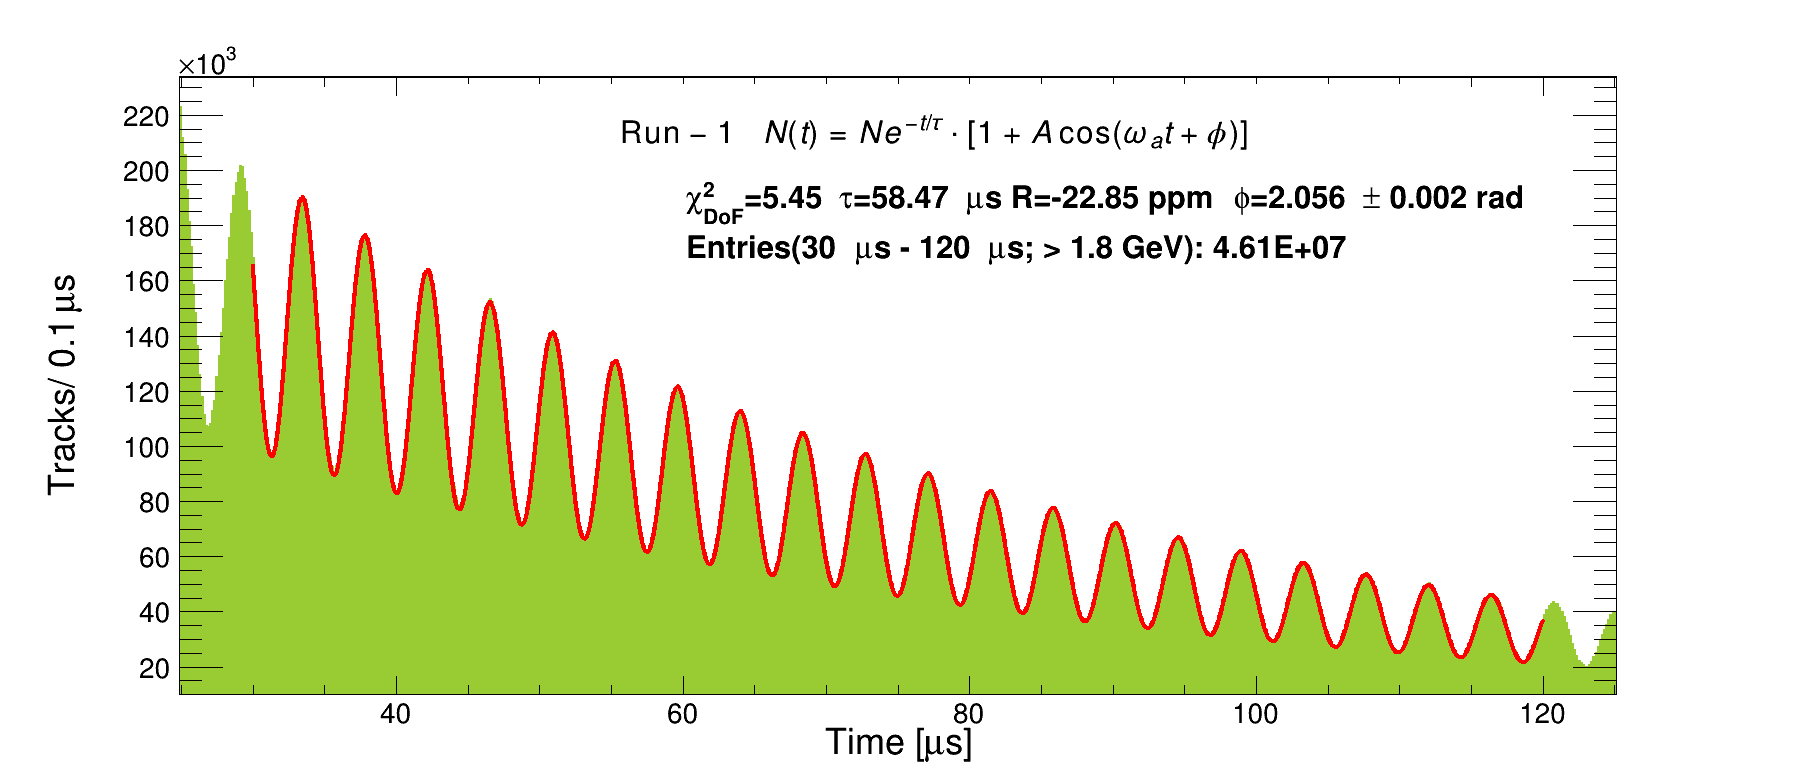

In [19]:
h_wiggle.Fit('func','REM') # fit in range (R), TMinut fit (M), Minos errors (E)

# Get the fit parameters
chi2=func.GetChisquare()
ndf=func.GetNDF()
ch2ndf=chi2/ndf
LT = func.GetParameter(1)
LT_error = func.GetParError(1)
R= func.GetParameter(3)
phi = func.GetParameter(4)
phi_error = func.GetParError(4)

# Set and draw legend
legend =  TLegend(0.25,0.65,0.78,0.89)
legend.SetHeader(r"\mathrm{Run-1} \ N(t)=Ne^{-t/\tau} \cdot [1+A\cos(\omega_{a}t+\phi)]", "C")
# legend.SetHeader(r"\mathrm{Sim.} \ N(t)=Ne^{-t/\tau} \cdot [1+A\cos(\omega_{a}t+\phi)]", "C")
legenValue1 = "#chi^{2}_{DoF}=%.2f #tau=%.2f #mus R=%0.2f ppm #phi=%.3f #pm %.3f rad" % (ch2ndf, LT, R, phi, phi_error)
legenValue2 = "Entries("+str(xmin)+" #mus - "+str(xmax)+" #mus; > 1.8 GeV): %.2E" % entries
legend.AddEntry(func, "#splitline{"+str(legenValue1)+"}{"+str(legenValue2)+"}", "")
gStyle.SetLegendBorderSize(0)
gStyle.SetLegendTextSize(0.044)
legend.Draw()

c.Draw()
c.SaveAs("fig/wiggle_blinded.png")